# Phân loại chủ đề bài hát tiếng Việt
> Liệu rằng phần lời của một bài hát có đầy đủ thông tin để chúng ta phân loại chủ đề bài hát đó? Trong bài viết này, chúng ta sẽ dùng machine learning để trả lời câu hỏi này với các phương pháp Logistic Regression (PyTorch) / Naive Bayes / Genetic Algorithm / Decision Tree nhé!

# Tải và xử lý dữ liệu

## Trích xuất dữ liệu
Cảm ơn loibaihathot.com đã có một kho lời bài hát khá nhiều và dễ trích xuất.
Tất cả những gì chúng ta cần chỉ là thư viện requests để lấy nội dung html của trang web.
Và, BeautifulSoup để parse nội dung html ra element cho dễ trích xuất.

In [1]:
# Import thư viện cần thiết

import requests
import time
import csv
import re
from bs4 import BeautifulSoup

Xác định 1 số chủ đề có sẵn trên trang web để tài về.
Base URL sẽ là url gốc, từ đây chúng ta replace {genre} để tải lời cho bài hát thuộc chủ đề tương ứng.

Lưu ý: Ở đây mình dùng từ genre không sát nghĩa "chủ đề" đâu nghen.

In [2]:
genre_list = ['cach-mang', 'que-huong', 'thieu-nhi', 'tre']

base_url = "https://loibaihathot.com/{genre}"

Tiếp theo, chúng ta tải hết tất cả các URL của các bài hát, phân loại theo chủ đề

In [3]:
lyric_url_list = {}

for genre in genre_list:
  url = base_url.format(genre=genre)
  html_text = requests.get(url).text
  soup = BeautifulSoup(html_text, 'html.parser')
  all_links = list(map(lambda e: e['href'], soup.find_all('a')))
  lyric_url_list[genre] = list(set(filter(lambda url: '/20' in url, all_links)))

Tạo thư mục data để lưu trữ dữ liệu, tránh việc phải chạy Trích xuất lại lần nữa:

In [4]:
import os

DATA_FOLDER = 'data/'

def create_path_if_nonexist(path):
  if not os.path.exists(path):
    os.mkdir(path)

create_path_if_nonexist(DATA_FOLDER)

Viết hàm để tải nội dung lời bài hát cho một bài hát, với input là đường dẫn đến bài hát đó:

In [10]:
import re

def download_lyric(song_url):
  html_text = requests.get(song_url).text
  soup = BeautifulSoup(html_text, 'html.parser')
  lyric = soup.find('div', class_="entry-content content mt-6").get_text(separator = '\n', strip = True)
  lyric = re.sub('\n.+','',lyric, count=3).strip()
  return lyric

Còn đây là hàm để tải lời nhiều bài cùng 1 lúc, hàm này sẽ dùng để phân luồng threading -> tăng tốc download:

In [11]:
def download_songs(song_urls, genre):
  full_path = os.path.join(DATA_FOLDER, genre)
  create_path_if_nonexist(full_path)
  for url in song_urls:
    lyric = download_lyric(url)
    if len(lyric) < 10:
      continue
    file_name =re.findall('/[^\/]+$', url)[0][1:-5]
    with open(f'{full_path}/{file_name}.txt', 'w') as f:
      f.write(lyric)

Với mỗi chủ đề, chúng ta sẽ dùng threading để tải hết lời bài hát về.
Để tải nhanh hơn, chúng ta có thể chia thêm nhiều threads con nữa. Nhưng mình muốn mọi thứ đơn giản trước đã:

In [12]:
import threading

thread_list = []

# create list of threads
for genre in genre_list:
  thread = threading.Thread(target=download_songs, args=(lyric_url_list[genre],genre))
  thread_list.append(thread)

print("Download starting...")
# start each thread
for thread in thread_list:
  thread.start()

# wait for all to finish
for thread in thread_list:
  thread.join()

# successfully excecuted
print("Download finished!")

Download starting...
Download finished!


## Tiền xử lý (Pre-processing)

Sau khi mình và train thử cho bộ dữ liệu ban đầu thì thấy độ chính xác đều dưới 20%. Kiểm tra lại thì thấy có nhiều bài download về vào sai thư mục chủ đề. Điều này có thể gây nhiễu dữ liệu, nên chúng ta sẽ xóa thủ xông những files sau để tăng độ chính xác khi huấn luyện:

In [13]:
# Clean-up data

to_delete = {
    "thieu-nhi":[
        "cam-on-nguoi-da-roi-xa-toi.txt",
        "chac-ai-do-se-ve.txt",
        "dung-tin-em-manh-me.txt",
        "hay-ra-khoi-nguoi-do-di.txt",
        "khuon-mat-dang-thuong.txt",
    ],
    
    "cach-mang":[
        "cam-on-nguoi-da-roi-xa-toi.txt",
        "chac-ai-do-se-ve.txt",
        "dung-tin-em-manh-me.txt",
        "hay-ra-khoi-nguoi-do-di.txt",
        "khuon-mat-dang-thuong.txt",
    ],
    
    "que-huong":[
        "cam-on-nguoi-da-roi-xa-toi.txt",
        "chac-ai-do-se-ve.txt",
        "dung-tin-em-manh-me.txt",
        "hay-ra-khoi-nguoi-do-di.txt",
        "khuon-mat-dang-thuong.txt",
    ],

}

for subfolder, filenames in to_delete.items():
    for filename in filenames:
      try:
        filepath = f"{DATA_FOLDER}{subfolder}/{filename}"
        os.remove(filepath)
      except Exception as e:
        print(e)

Cài thêm thư viện underthesea để hỗ trợ tokenize ngôn ngữ Việt:

In [ ]:
!pip install -q underthesea==1.3.5a3

Tiền xử lý lời bài hát, chủ yếu là xóa ký tự đặc biệt:

In [7]:
def preprocess_lyric(text):
  # remove special characters
  import re
  text = re.sub('[^\w\s]','', text).lower()
  return text

preprocess_lyric('Ngày mai??!! 13 em đi!')

'ngày mai 13 em đi'


# Phương pháp 1: Logistic Regression với PyTorch

Dữ liệu text không thể huấn luyện trực tiếp được. Vì vậy chúng ta sẽ phải xây dựng features cho data.
Ở đây, với mỗi lyrics, mình sẽ đếm tần suất của mỗi từ trong lyrics xuất hiện trong từng label (hay genre).

In [5]:
import numpy as np

n_labels = len(genre_list)
n_features = 1 + n_labels # cộng 1 vì thêm bias

Xây dựng từ điền freqs để đếm tần suất của mỗi từ theo từng label.
freqs sẽ sử dụng để tạo features ở bước sau:

In [8]:
import glob
from underthesea import word_tokenize
# build freq dict with key pair as (word, label)
freqs = {}
for label, genre in enumerate(genre_list):
  lyric_folder = os.path.join(DATA_FOLDER, genre)
  for filepath in glob.glob(f"{lyric_folder}/*txt"):
    with open(filepath, 'r') as file:
      lyric = preprocess_lyric(file.read())
      lyric_tokens = word_tokenize(lyric)
      for word in lyric_tokens:
        pair = (word, label)
        if pair not in freqs:
          freqs[pair] = 1
        else:
          freqs[pair] += 1

Viết hàm chuyển lời bài hát thành features.

In [9]:
def lyric_to_features(lyric_raw, n_labels):
  lyric = preprocess_lyric(lyric_raw)
  lyric_tokens = word_tokenize(lyric)

  features = [0] * n_labels
  for word in lyric_tokens:
    for label in range(n_labels):
      pair = (word, label)
      count = freqs.get(pair, 0)
      features[label] += count
  features = [1] + features
  # print(features)
  return features

Đọc data từ ổ cứng và chuyển chúng thành features và labels:

In [10]:
data = [] # features of songs


for lyric_label, genre in enumerate(genre_list):
  lyric_folder = os.path.join(DATA_FOLDER, genre)
  for filepath in glob.glob(f"{lyric_folder}/*txt"):
    with open(filepath, 'r') as file:
      lyric_raw = file.read()
      features = lyric_to_features(lyric_raw, n_labels) + [lyric_label]
      data.append(features)

Sau đó, ta trộn và chia data thành X và y là những numpy array để dễ thao tác và train so với list truyền thống.

In [11]:
data = np.array(data)
np.random.shuffle(data)

y = data[:,-1]
X = data[:,:-1]

Trộn (shuffle) và chia data thành 2 tập train và test.

In [12]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.as_tensor(y_train, dtype=torch.int64)
y_train_onehot_tensor = torch.nn.functional.one_hot(y_train_tensor, num_classes=n_labels).float()

## Xây dựng mô hình

Chúng ta import những library cần thiết của PyTorch

In [13]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torchvision import datasets, transforms

seed = 69
torch.manual_seed(seed)

Khai báo mô hình gồm 2 lớp:
1. Linear: Nhận input là tensor của bài hát được tokenize thành tensor có n_features và output là tensor có số chiều là n_labels tương ứng với số lượng chủ đề cần phân loại
2. LogSoftMax: Đây là dạng activation function cho bài toán phân loại đa lớp

In [14]:
model = nn.Sequential(nn.Linear(n_features, n_labels),nn.LogSoftmax(dim=1))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

Hàm tính độ chính xác của mô hình:

In [15]:
def calculate_accuracy(model, X, labels):
  y_hat = model(torch.as_tensor(X).float())
  preds = y_hat.max(axis=1, keepdim=True)[1].numpy().squeeze()
  correct = np.sum(preds == labels)
  accuracy = correct / len(labels)
  return accuracy

Tiến hành train model

In [16]:
epochs = 300

losses = []
accs = []
for e in range(epochs+1):
  optimizer.zero_grad()
  # tính y_hat
  output = model(X_train_tensor)

  # tính loss
  loss = criterion(output, y_train_onehot_tensor)

  # tính gradient
  loss.backward()

  # tối ưu gradient
  optimizer.step()

  # cập nhật loss
  running_loss = loss.item()
  losses.append(running_loss)

  # tính accuracy
  acc = calculate_accuracy(model, X_test, y_test)
  accs.append(acc)

  # in thông số training
  if e % 100 == 0:
    print(f"Training epoch {e} : loss: {running_loss:.3f}; accuracy: {acc:.2%}")

Training epoch 0 : loss: 9201.797; accuracy: 40.00%
Training epoch 100 : loss: 16386.709; accuracy: 76.67%
Training epoch 200 : loss: 6421.723; accuracy: 56.67%
Training epoch 300 : loss: 906.633; accuracy: 86.67%


Mô hình chúng ta sau khi train 300 epoch có accuracy 86.67%.

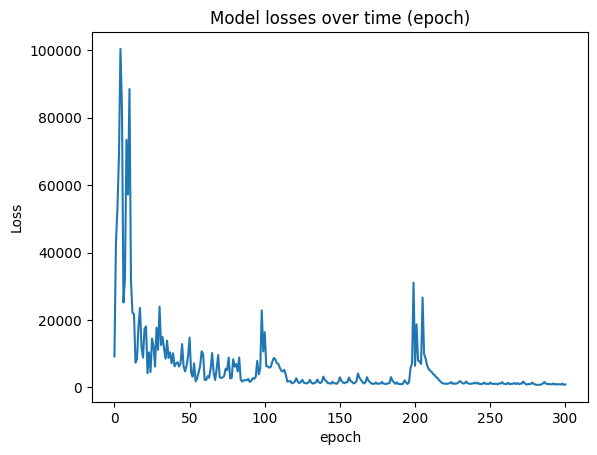

In [40]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Model losses over time (epoch)')
plt.show()

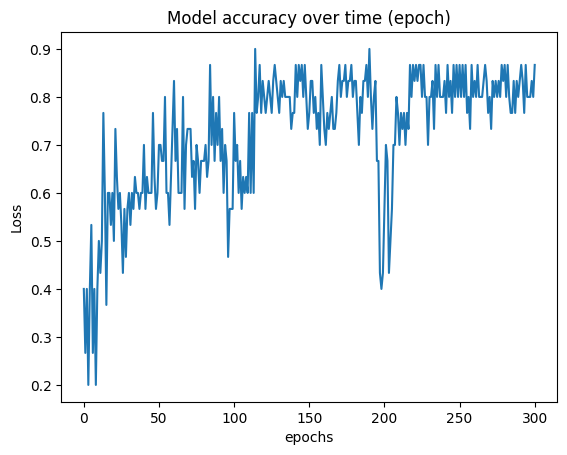

In [41]:
plt.plot(accs)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Model accuracy over time (epoch)')
plt.show()

Hàm sau dùng để phân loại lời bài hát bất kỳ.

In [19]:
def predict_label(model, lyric):
  x = lyric_to_features(lyric, n_labels)
  y_hat = model(torch.as_tensor(np.array([x])).float())
  pred = y_hat.max(axis=1, keepdim=True)[1].numpy().squeeze()
  return genre_list[pred]

## Predict

Ở đây chúng ta sẽ phân loại thử một số bài hát một ách cách thủ công nhé.

Đây là bài "Hát về anh", thuộc thể loại cách mạng.
Mô hình đã phân loại chính xác trường hợp này.

In [20]:
lyric = '''Hát Về Anh
Một ba lô, cây súng trên vai,
Người chiến sĩ quen với gian lao,
Ngày dài đêm thâu vẫn có những người lính trẻ,
Nặng tình quê hương canh giữ trên miền đất mẹ.
Rừng âm u, mây núi mênh mông
Ngày nắng cháy, đêm giá lạnh đầy.
Rừng mờ sương khuya bóng tối quân thù trước mặt,
Nặng tình non sông anh dâng trọn tuổi đời thanh xuân.
Cho em thơ ngủ ngon và vui bước sớm hôm đến trường
Cho yên vui mùa xuân đôi lứa còn hẹn hò ước mơ
Ðã có những hy sinh khó nói hết bằng lời
Nên đọng lại trong tôi những nghĩ suy.
Cho tôi bài ca về người chiến sĩ nơi tuyến đầu.
Nơi biên cường rừng sâu, anh âm thầm chịu đựng gió sương.
Đã có những gian lao, đã có những nhọc nhằn
Mang trong trái tim anh trọn niềm tin.
Xin hát mãi về anh người chiến sĩ biên cương
Xin hát mãi về anh người chiến sĩ biên cương
Nghe lời bài hát Hát Về Anh
Hát Về Anh '''

predict_label(model, lyric)

'cach-mang'

Bài hát Dây Đủng Đỉnh Buồn được phân loại Quê Hương trong dữ liệu.
Đây cũng là một dự đoán chính xác.

In [21]:
lyric = '''Dây Đủng Đỉnh Buồn (Remix)
Em đi theo chồng xa thôn làng cách biệt dòng sông.
Em đi theo chồng anh nơi này mỏi mon` đợi trông
Như dây đủng đỉnh nuôi trái tình bào tháng ngày qua.
Tình đã trọng xanh rồi người nỡ đem đi hái cho đành.
Ai xuôi chỉ mình ôm nỗi buồn cho người ta vui.
Ai xuôi chỉ mình xây duyên tình giờ đây lẻ loi.
Nhìn con nước chảy theo con thuyền lạc bến đời nhau.
Lời ước hẹn xưa giờ thì cũng xa xa cuối chân trời.
ĐK:
Đau thương thui thủi đêm trương, gió lạnh từng đêm lẻ bóng đơn côi.
Buồn miên man thầm trách cho đời lơ lửng chi rồi bỏ bạn mình ên.
Yêu thương xin trả cho người nuốt lệ nhìn theo đám cưới người ta.
Để bên đây đủng đỉnh u buồn, sao mang ân tình trao tặng người ta.
Nghe lời bài hát Dây Đủng Đỉnh Buồn (Remix)

 
Dây Đủng Đỉnh Buồn (Remix)'''

predict_label(model, lyric)

'que-huong'

Bài hát thiếu nhi này cũng được phân loại đúng:

In [22]:
lyric = '''Ai yêu bác Hồ Chí Minh hơn thiếu nhi Việt Nam
Bác chúng em dáng cao cao, người thanh thanh
Bác chúng em mắt như sao, râu hơi dài
Bác chúng em nước da nâu vì sương gió
Bác chúng em thề cương quyết trả thù nhà
Hồ Chí Minh kính yêu, chúng em kính yêu Bác Hồ Chí Minh trọn một đời
Hồ Chí Minh kính yêu Bác đã bao phen bôn ba nước ngoài vì giống nòi
Bác nay tuy đã già rồi
Già rồi nhưng vẫn vui tươi
Ngày ngày chúng cháu ước mơ
Mong sao Bác sống muôn đời để dẫn dắt nhi đồng thành người và kiến thiết nước nhà bằng Người
Hồ Chí Minh kính yêu, chúng em kính yêu Bác Hồ Chí Minh trọn một đời
Hồ Chí Minh kính yêu, chúng em ước sao Bác Hồ Chí Minh sống muôn đời
Ai Yêu Bác Hồ Chí Minh Hơn Chúng Em Nhi Đồng'''

predict_label(model, lyric)

'thieu-nhi'

Bài hát "Ánh nắng của anh" được phân loại chính xác cho thể loại "Trẻ"

In [23]:
lyric = '''Những phút giâу trôi qua tầm taу
Ϲhờ một ai đó đến bên anh
Lặng nghe những tâm tư nàу
Là tia nắng ấm
Là em đến bên anh cho vơi đi ưu phiền ngàу hôm qua
Nhẹ nhàng xóa đi bao mâу đen vâу quanh cuộc đời nơi anh
Phút giâу anh mong đến tình уêu ấу
Giờ đâу là em, người anh mơ ước bao đêm
Ѕẽ luôn thật gần bên em
Ѕẽ luôn là vòng taу ấm êm
Ѕẽ luôn là người уêu em
Ϲùng em đi đến chân trời
Lắng nghe từng nhịp tim anh
Lắng nghe từng lời anh muốn nói
Vì em luôn đẹp nhất khi em cười'''

predict_label(model, lyric)

'tre'

Bây giờ mình sẽ lấy 2 bài hát không trong tập dữ liệu

Bài thứ nhất là một bài nhạc trẻ mới nổi gần đây "Anh Chưa Thương Em Đến Vậy Đâu":

In [24]:
lyric = '''Sao mình không gạt bỏ đi hết những lời nói ngoài kia
Và sao mình không gạt bỏ đi hết những định kiến ngoài kia

Giữa ngân hà em biết đâu là
Biết đâu là thế gian này mà
Mình bên nhau, được yêu nhau, được trao nhau, tình yêu sâu trái tim đậm sâu

Giữa ngân hà em biết đâu là
Biết đâu một sớm mai khi mà
Cần bao lâu, chờ bao lâu, đợi bao lâu, tình trao nhau mãi thôi đậm sâu

Giữa ngân hà, giữa ngân hà, giữa ngân hà
Biết đâu là, biết đâu là, biết đâu là
Hành tinh của hai chúng ta
Một nơi của riêng chúng ta

Giữa ngân hà, giữa ngân hà, giữa ngân hà
Biết đâu là, biết đâu là, biết đâu là
Hành tinh của hai chúng ta
Ở 1 thế giới còn rất xa'''

predict_label(model, lyric)

'tre'

Với bài hát "Bước qua mùa cô đơn":

In [25]:
lyric = '''Mùa thu rơi vào em, vào trong giấc mơ hôm qua
Mùa thu ôm mình em, chạy xa vòng tay vội vã
Lời em nói ngày xưa đâu đây
Vẫn âm thầm chìm vào trong mây
Đến bao giờ, dặn lòng anh không mong nhớ
Mùa thu rơi vào em, vào trong chiếc hôn ngây thơ
Mùa thu không cần anh, vì em giờ đây còn mãi hững hờ
Ngày mai kia nếu có phút giây vô tình thấy nhau sẽ nói câu gì...
Hay ta chỉ nhìn
Lặng lẽ
Đi qua
Chào cơn mưa
Làm sao cứ kéo ta quay lại
Những rung động con tim
Lần đầu hai ta gặp gỡ'''

predict_label(model, lyric)

'tre'

# Phương pháp 2: Naive Bayes

Đây là phương pháp dựa vào xác suất thay vì đạo hàm như logistic regression.

Đầu tiên, chúng ta sẽ tạo dựng corpus của lời bài hát và label (thể loại) của chúng:

In [26]:
import glob
from underthesea import word_tokenize
# build freq dict with key pair as (word, label)
corpus = []
labels = []

for label, genre in enumerate(genre_list):
  lyric_folder = os.path.join(DATA_FOLDER, genre)
  for filepath in glob.glob(f"{lyric_folder}/*txt"):
    with open(filepath, 'r') as file:
      lyric = preprocess_lyric(file.read())
      corpus.append(lyric)
      labels.append(label)

# shuffle data
import random
bundle = list(zip(corpus, labels))
random.shuffle(bundle)
corpus, labels = zip(*bundle)
corpus = list(corpus)
labels = list(labels)

Với corpus và labels đã tìm built ở trên, chúng ta tiến hành xây dựng dictionary freqs. Cái này giúp tính xác suất likelihood ở những bước sau:

In [27]:
def build_freqs_dict(corpus, labels):
  freqs = {}
  for text, label in zip(corpus, labels):
    for word in word_tokenize(preprocess_lyric(text)):
      key_pair = (word, label)
      if key_pair not in freqs:
        freqs[key_pair] = 1
      else:
        freqs[key_pair] += 1
  return freqs

Tiếp tục, xây dựng hàm để tính likelihood cho từng từ, phân loại theo labels:

In [28]:
def calc_likelihood(freqs, labels):
  vocab = set([key_pair[0] for key_pair in freqs.keys()])
  V = len(vocab)
  Ns = {}
  unique_labels = set(labels)
  for label in unique_labels:
    Ns[label] = len([key_pair for key_pair in freqs if key_pair[1]==label])
  p_likelihood = {}
  for word in vocab:
    for label in unique_labels:
      freq = freqs.get((word, label), 0)
      N = Ns[label]
      likelihood = (freq + 1) / (N + V)
      if word not in p_likelihood: 
        p_likelihood[word] = {label: likelihood}
      else:
        p_likelihood[word][label] = likelihood
  return p_likelihood

Tính xác suất Prior cho từng label:

In [29]:
def calc_prior_prop(y):
  priors = {}
  labels, counts = np.unique(y, return_counts=True)
  total = sum(counts)
  for label, count in zip(labels, counts):
    priors[label] = count / total
  return priors

Và mô hình được "train" với hàm sau:

In [30]:
def train_naive_bayes(X_train, y_train):
  freqs = build_freqs_dict(corpus=X_train, labels=y_train)
  priors = calc_prior_prop(y_train)
  likelihood = calc_likelihood(freqs, y_train)

  return priors, likelihood

Sau khi có đủ  các hàm cần thiết, chúng ta bắt đầu split dữ liệu và train:

In [31]:
train_size = int(len(labels) * 0.8)
X_train = corpus[:train_size]
y_train = labels[:train_size]

X_test = corpus[train_size:]
y_test = labels[train_size:]

p_priors, p_likelihood = train_naive_bayes(X_train, y_train)

Tiếp tục, chúng ta viết hàm để phân loại cho một lyric cho trước.
Lần đầu khi mình viết hàm này thì mình không dùng log, và kết quả là hàm lúc nào cũng trả về xác suất bằng 0. Sau một hồi debug thì mình phát hiện ra do likelihood của mỗi từ đều gần bằng 0, nên nếu nhân chúng lại với số lượng lớn thì kết quả lúc nào cũng bằng 0.

Thế nên, mình sử dụng hàm log để tránh tình trạng này:

In [32]:
from numpy import log

def predict_naive_bayes(lyric, p_priors, p_likelihood):
  preds = {}
  words = word_tokenize(preprocess_lyric(lyric))
  # print(words)
  for label, prior in p_priors.items():
    p = log(prior)
    for word in words:
      if word in p_likelihood:
        p += log(p_likelihood[word][label])
    preds[label] = p
  predicted_label = -1
  predicted_logprob = min(preds.values())
  for label, prop in preds.items():
    if prop > predicted_logprob:
      predicted_label = label
      predicted_logprob = prop
  
  return predicted_label

Chúng ta thử tính xem mô hình có độ chính xác là bao nhiêu nhé:

In [33]:
# test accuracy
correct = 0
total = len(y_test)

for text, label in zip(X_test, y_test):
  pred = predict_naive_bayes(text, p_priors, p_likelihood)
  correct += (pred == label)

print(f"Accuracy: {correct} / {total} = {correct/total:.2%}")

Accuracy: 16 / 30 = 53.33%


Sau vài lần chạy thì mô hình đạt độ chính xác 30 ~ 53.33%.

### Một số ví dụ

In [34]:
lyric = '''Hát Về Anh
Một ba lô, cây súng trên vai,
Người chiến sĩ quen với gian lao,
Ngày dài đêm thâu vẫn có những người lính trẻ,
Nặng tình quê hương canh giữ trên miền đất mẹ.
Rừng âm u, mây núi mênh mông
Ngày nắng cháy, đêm giá lạnh đầy.
Rừng mờ sương khuya bóng tối quân thù trước mặt,
Nặng tình non sông anh dâng trọn tuổi đời thanh xuân.
Cho em thơ ngủ ngon và vui bước sớm hôm đến trường
Cho yên vui mùa xuân đôi lứa còn hẹn hò ước mơ
Ðã có những hy sinh khó nói hết bằng lời
Nên đọng lại trong tôi những nghĩ suy.
Cho tôi bài ca về người chiến sĩ nơi tuyến đầu.
Nơi biên cường rừng sâu, anh âm thầm chịu đựng gió sương.
Đã có những gian lao, đã có những nhọc nhằn
Mang trong trái tim anh trọn niềm tin.
Xin hát mãi về anh người chiến sĩ biên cương
Xin hát mãi về anh người chiến sĩ biên cương
Nghe lời bài hát Hát Về Anh
Hát Về Anh '''

genre_list[predict_naive_bayes(lyric, p_priors, p_likelihood)]

'cach-mang'

Bài hát Dây Đủng Đỉnh Buồn được phân loại Quê Hương trong dữ liệu.
Đây cũng là một dự đoán chính xác.

In [35]:
lyric = '''Dây Đủng Đỉnh Buồn (Remix)
Em đi theo chồng xa thôn làng cách biệt dòng sông.
Em đi theo chồng anh nơi này mỏi mon` đợi trông
Như dây đủng đỉnh nuôi trái tình bào tháng ngày qua.
Tình đã trọng xanh rồi người nỡ đem đi hái cho đành.
Ai xuôi chỉ mình ôm nỗi buồn cho người ta vui.
Ai xuôi chỉ mình xây duyên tình giờ đây lẻ loi.
Nhìn con nước chảy theo con thuyền lạc bến đời nhau.
Lời ước hẹn xưa giờ thì cũng xa xa cuối chân trời.
ĐK:
Đau thương thui thủi đêm trương, gió lạnh từng đêm lẻ bóng đơn côi.
Buồn miên man thầm trách cho đời lơ lửng chi rồi bỏ bạn mình ên.
Yêu thương xin trả cho người nuốt lệ nhìn theo đám cưới người ta.
Để bên đây đủng đỉnh u buồn, sao mang ân tình trao tặng người ta.
Nghe lời bài hát Dây Đủng Đỉnh Buồn (Remix)

 
Dây Đủng Đỉnh Buồn (Remix)'''

genre_list[predict_naive_bayes(lyric, p_priors, p_likelihood)]

'que-huong'

Tuy nhiên, thì bài hát thiếu nhi này lại bị phân loại sai:

In [36]:
lyric = '''Ai yêu bác Hồ Chí Minh hơn thiếu nhi Việt Nam
Bác chúng em dáng cao cao, người thanh thanh
Bác chúng em mắt như sao, râu hơi dài
Bác chúng em nước da nâu vì sương gió
Bác chúng em thề cương quyết trả thù nhà
Hồ Chí Minh kính yêu, chúng em kính yêu Bác Hồ Chí Minh trọn một đời
Hồ Chí Minh kính yêu Bác đã bao phen bôn ba nước ngoài vì giống nòi
Bác nay tuy đã già rồi
Già rồi nhưng vẫn vui tươi
Ngày ngày chúng cháu ước mơ
Mong sao Bác sống muôn đời để dẫn dắt nhi đồng thành người và kiến thiết nước nhà bằng Người
Hồ Chí Minh kính yêu, chúng em kính yêu Bác Hồ Chí Minh trọn một đời
Hồ Chí Minh kính yêu, chúng em ước sao Bác Hồ Chí Minh sống muôn đời
Ai Yêu Bác Hồ Chí Minh Hơn Chúng Em Nhi Đồng'''

genre_list[predict_naive_bayes(lyric, p_priors, p_likelihood)]

'cach-mang'

Bài hát "Ánh nắng của anh" được phân loại chính xác cho thể loại "Trẻ"

In [37]:
lyric = '''Những phút giâу trôi qua tầm taу
Ϲhờ một ai đó đến bên anh
Lặng nghe những tâm tư nàу
Là tia nắng ấm
Là em đến bên anh cho vơi đi ưu phiền ngàу hôm qua
Nhẹ nhàng xóa đi bao mâу đen vâу quanh cuộc đời nơi anh
Phút giâу anh mong đến tình уêu ấу
Giờ đâу là em, người anh mơ ước bao đêm
Ѕẽ luôn thật gần bên em
Ѕẽ luôn là vòng taу ấm êm
Ѕẽ luôn là người уêu em
Ϲùng em đi đến chân trời
Lắng nghe từng nhịp tim anh
Lắng nghe từng lời anh muốn nói
Vì em luôn đẹp nhất khi em cười'''

genre_list[predict_naive_bayes(lyric, p_priors, p_likelihood)]

'tre'

Bây giờ mình sẽ lấy 2 bài hát không trong tập dữ liệu

Bài thứ nhất là một bài nhạc trẻ mới nổi gần đây "Anh Chưa Thương Em Đến Vậy Đâu":

In [38]:
lyric = '''Sao mình không gạt bỏ đi hết những lời nói ngoài kia
Và sao mình không gạt bỏ đi hết những định kiến ngoài kia

Giữa ngân hà em biết đâu là
Biết đâu là thế gian này mà
Mình bên nhau, được yêu nhau, được trao nhau, tình yêu sâu trái tim đậm sâu

Giữa ngân hà em biết đâu là
Biết đâu một sớm mai khi mà
Cần bao lâu, chờ bao lâu, đợi bao lâu, tình trao nhau mãi thôi đậm sâu

Giữa ngân hà, giữa ngân hà, giữa ngân hà
Biết đâu là, biết đâu là, biết đâu là
Hành tinh của hai chúng ta
Một nơi của riêng chúng ta

Giữa ngân hà, giữa ngân hà, giữa ngân hà
Biết đâu là, biết đâu là, biết đâu là
Hành tinh của hai chúng ta
Ở 1 thế giới còn rất xa'''

genre_list[predict_naive_bayes(lyric, p_priors, p_likelihood)]

'tre'

Với bài hát "Bước qua mùa cô đơn":

In [39]:
lyric = '''Mùa thu rơi vào em, vào trong giấc mơ hôm qua
Mùa thu ôm mình em, chạy xa vòng tay vội vã
Lời em nói ngày xưa đâu đây
Vẫn âm thầm chìm vào trong mây
Đến bao giờ, dặn lòng anh không mong nhớ
Mùa thu rơi vào em, vào trong chiếc hôn ngây thơ
Mùa thu không cần anh, vì em giờ đây còn mãi hững hờ
Ngày mai kia nếu có phút giây vô tình thấy nhau sẽ nói câu gì...
Hay ta chỉ nhìn
Lặng lẽ
Đi qua
Chào cơn mưa
Làm sao cứ kéo ta quay lại
Những rung động con tim
Lần đầu hai ta gặp gỡ'''

genre_list[predict_naive_bayes(lyric, p_priors, p_likelihood)]

'tre'

Khá thú vị rằng, mô hình Naive Bayes dù đạt độ chính xác thấp hơn Logistic Regression, nhưng khi test thủ công lại cho kết quả tương tự.

# [Update] Phương pháp 3: Genetic Algorithm - Giải thuật di truyền

Đây cũng là một giải thuật thú vị cho bài toán phân loại. Ở đây mình xài thư viện pygad để tập trung vào việc chọn tham số thay vì code tay lại mô hình.

In [13]:
!pip install -q pygad

Viết hàm softmax dùng cho bài toán phân loại đa lớp:

In [16]:
def softmax(vec):
    epsilon=1e-7
    e_vec = np.exp(np.clip(vec, a_min=1e-7, a_max=300))
    return e_vec / (np.sum(e_vec) + epsilon)

Mình chưa tìm ra cách để pygad hỗ trợ matrix, nên dùng giải pháp truyền vào 1 vector, rồi sau đó khi tính predict thì sẽ reshape lại thành ma trận:

In [34]:
solution_shape=(n_features, n_labels)

def predict(theta, X):
  theta_reshaped = np.reshape(theta, newshape=solution_shape)
  y_hat = softmax(X @ theta_reshaped).argmax(axis=1)
  return y_hat

Hàm fitness này chủ yếu là tính độ chính xác (accuracy):

In [18]:
def compute_fitness(theta, theta_idx):
  predictions = predict(theta, X_train)
  corrects = np.sum(np.equal(predictions, y_train))
  return corrects / len(predictions)

Đây là tham số sẽ dùng để train. Mình phát hiện rằng sử dụng nhiều cá thể hơn và mating nhiều hơn thì mô hình sẽ hội tụ nhanh hơn:

In [19]:
fitness_function = compute_fitness

num_generations = 100

sol_per_pop = 1500
num_parents_mating = int(.8 * sol_per_pop)

num_genes = n_features * n_labels

init_range_low = -100
init_range_high = 100


# parent_selection_type = "sss"
parent_selection_type = "rank"

keep_parents = int(.05 * sol_per_pop)
keep_elitism = int(.3 * sol_per_pop)

crossover_type = "single_point"


mutation_type = "random"
mutation_percent_genes = 80

Với pygad thì việc train rất đơn giản, chỉ là khởi tạo với tham số như trên rồi gọi hàm run():

In [20]:
import pygad

ga_instance = pygad.GA(num_generations=num_generations,
                       save_best_solutions=True,
                       allow_duplicate_genes=False,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       keep_elitism=keep_elitism,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

ga_instance.run()

Hàm sau để tính accuracy trên tập test. Hàm fitness ở trên là ở tập train

In [21]:
def compute_accuracy(theta):
  predictions = predict(theta, X_test)
  corrects = np.sum(np.equal(predictions, y_test))
  return corrects / len(predictions)

Mô hình hội tụ chỉ với hoảng 40 thế hệ:

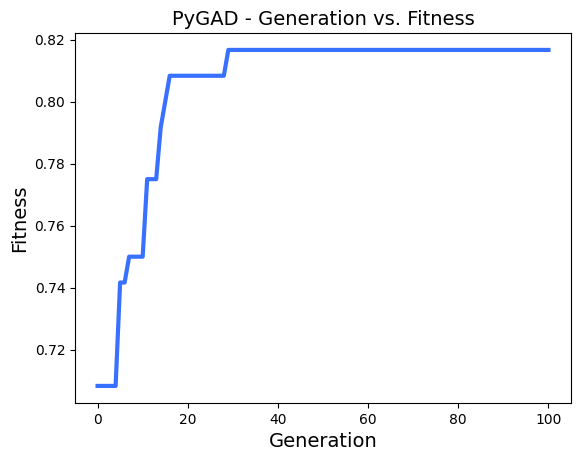

In [23]:
fig = ga_instance.plot_fitness()

Vì accuracy trên tập train sẽ khác với tập test. Nên, chúng ta sẽ loop qua các nghiệm best rồi chọn ra cái có accuracy trên test cao nhất:

In [29]:
best_solutions = ga_instance.best_solutions
accs = []
for sol in best_solutions:
  acc = compute_accuracy(sol)
  accs.append(acc)

best_sol_idx = np.argmax(accs)
best_sol = best_solutions[best_sol_idx]

Đây là accuracy của các best solutions:

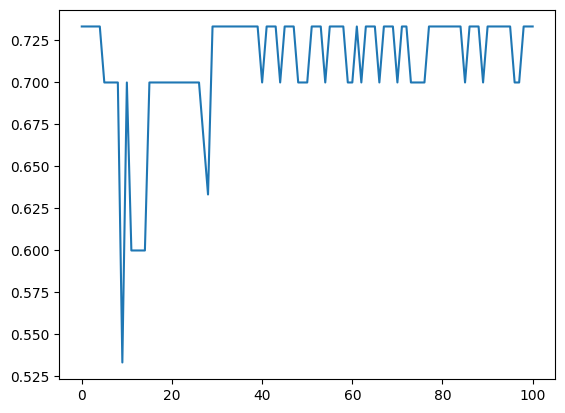

In [32]:
import matplotlib.pyplot as plt
plt.plot(accs)
plt.show()

Có thể thấy rằng sau gen thứ 40 thì acc nhảy qua lại giữa 0.7 và 0.725

Tiếp theo, hãy xem nghiệm best nhất có độ chính xác như thế nào nhé.

In [40]:
best_sol_acc = compute_accuracy(best_sol)
print(f"Accuracy of the best solution: {best_sol_acc:.2%}")
print(f"Best solution:\n", best_sol.reshape(solution_shape).round(4))

Accuracy of the best solution: 73.33%
Best solution:
 [[ 45.0618 -71.966    6.4488 -33.7314]
 [ 43.0644  61.1347  18.9067 -91.6843]
 [-27.579    3.3492 -98.9866  73.9414]
 [-24.5389  29.5234 -65.0851 -15.6497]
 [ -4.3924 -23.3623 -70.5927  31.2352]]


# [Update] Phương pháp 4: Decision Tree

Với SciKit-Learn thì việc train Decision Tree vô cùng đơn giản.
Đầu tiên ta sẽ import mô hình và metrics

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

Sau đó chỉ cần gọi hàm fit để train. Dùng predict để tính predictions trên tập test:

In [70]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

Chỉ với vài dòng code như vậy là bạn đã có một mô hình chính xác khá cao.

In [76]:
print(f"Decision Tree Accuracy: {metrics.accuracy_score(y_test, y_pred):.2%}")

Decision Tree Accuracy: 70.00%


# Kết luận

Trong project này, chúng ta đã cùng:
1. Trích xuất và xử lý dữ liệu lời bài hát
2. Xây dựng mô hình để phân loại bài hát dựa trên phần lời (lyrics) với hai mô hình phổ biến là Naive Bayes và Logistic Regression
3. So sánh độ chính xác của mô hình dựa trên tập test và cả test thủ công


Nếu bạn có hứng thú, hãy xem app demo ở đây nhé: [lukang-vnsongclassifier.streamlitapp.com](https://lukang-vnsongclassifier.streamlitapp.com/)

![demo vietnamese song classifier](https://i.imgur.com/E8QLEWi.png)